Process_image.py - takes as input 16x16x3 matrix, corresponding to a Macroblock of the image

Outputs the result of the DCT transformation and Quantization

In [1]:
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import empty,arange,exp,real,imag,pi
from numpy.fft import rfft,irfft

Definitions for 2D DCT

Functions origionally written by Mark Newman <mejn@umich.edu>

Accessed from http://www-personal.umich.edu/~mejn/computational-physics/dcst.py

Source contains blurb : "You may use, share, or modify this file freely"

In [3]:
#### 2D DCT ####
def dct2(y):
    def dct(y):
        N = len(y)
        y2 = empty(2*N,float)
        y2[:N] = y[:]
        y2[N:] = y[::-1]

        c = rfft(y2)
        phi = exp(-1j*pi*arange(N)/(2*N))
        return real(phi*c[:N])
    
    M = y.shape[0]
    N = y.shape[1]
    a = empty([M,N],float)
    b = empty([M,N],float)

    for i in range(M):
        a[i,:] = dct(y[i,:])
    for j in range(N):
        b[:,j] = dct(a[:,j])

    return b

In [6]:
img_name = 'Add.png'
rgb = M = cv2.imread(img_name,1)
Q = 50

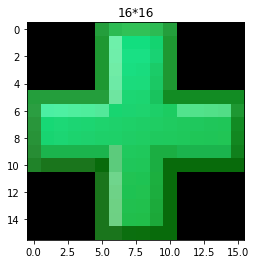

In [5]:
plt.title('16*16')
plt.imshow(M)

In [8]:
# Split bgr color channels
blue,green,red = cv2.split(M)
gray = cv2.cvtColor(M , cv2.COLOR_BGR2GRAY) # Convert color form BGR to Gray

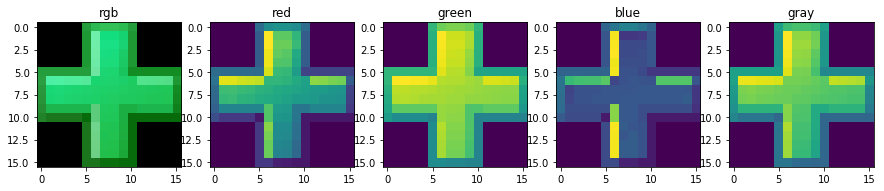

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(151)
plt.title('rgb')
plt.imshow(rgb)
plt.subplot(152)
plt.title('red')
plt.imshow(red)
plt.subplot(153)
plt.title('green')
plt.imshow(green)
plt.subplot(154)
plt.title('blue')
plt.imshow(blue)
plt.subplot(155)
plt.title('gray')
plt.imshow(gray)

In [39]:
# Convert color form BGR to Y_Cr_Cb
YCrCb = cv2.cvtColor(rgb , cv2.COLOR_RGB2YCR_CB) 
# Split Y_Cb_Cr channels
Y,Cb,Cr = cv2.split(YCrCb)

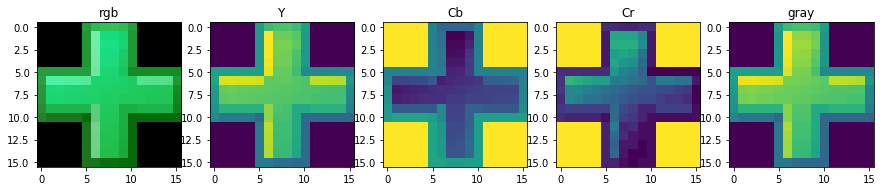

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(151)
plt.title('rgb')
plt.imshow(rgb)
plt.subplot(152)
plt.title('Y')
plt.imshow(Y)
plt.subplot(153)
plt.title('Cb')
plt.imshow(Cb)
plt.subplot(154)
plt.title('Cr')
plt.imshow(Cr)
plt.subplot(155)
plt.title('gray')
plt.imshow(gray)

In [12]:
Y1 = Y[:8,:8]
Y2 = Y[:8,8:]
Y3 = Y[8:,:8]
Y4 = Y[8:,8:]

In [36]:
# The strategy of subsampling is to keep the top left pixel for each 2x2 block
# We can also compute the mean of 2x2 block, the let it be the summary of the small block
def subsample(src):
    tmp = []
    for i in range(0,len(src),2):
        #print(i)
        #print(Cb[i])
        #print(Cb[i][::2])
        tmp.append(src[i][::2])
        #print(tmp)
    tmp = np.array(tmp)
    return tmp

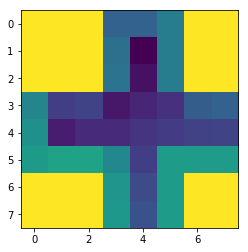

In [42]:
Cb1 = subsample(Cb)
plt.imshow(Cb1)

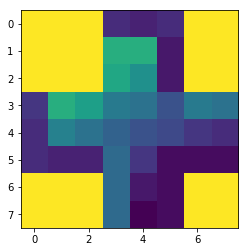

In [41]:
Cr1 = subsample(Cr)
plt.imshow(Cr1)

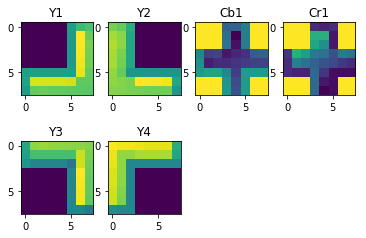

In [53]:
plt.subplot(241)
plt.title('Y1')
plt.imshow(Y1)
plt.subplot(242)
plt.title('Y2')
plt.imshow(Y2)
plt.subplot(243)
plt.title('Cb1')
plt.imshow(Cb1)
plt.subplot(245)
plt.title('Y3')
plt.imshow(Y3)
plt.subplot(246)
plt.title('Y4')
plt.imshow(Y4)
plt.subplot(244)
plt.title('Cr1')
plt.imshow(Cr1)

In [44]:
dct2_Y1 = dct2(Y1) 
dct2_Y2 = dct2(Y2) 
dct2_Y3 = dct2(Y3) 
dct2_Y4 = dct2(Y4) 
dct2_Cb1 = dct2(Cb1) 
dct2_Cr1 = dct2(Cr1) 

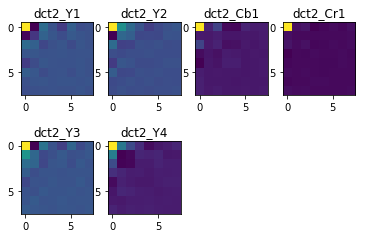

In [45]:
plt.subplot(241)
plt.title('dct2_Y1')
plt.imshow(dct2_Y1)
plt.subplot(242)
plt.title('dct2_Y2')
plt.imshow(dct2_Y2)
plt.subplot(243)
plt.title('dct2_Cb1')
plt.imshow(dct2_Cb1)
plt.subplot(245)
plt.title('dct2_Y3')
plt.imshow(dct2_Y3)
plt.subplot(246)
plt.title('dct2_Y4')
plt.imshow(dct2_Y4)
plt.subplot(244)
plt.title('dct2_Cr1')
plt.imshow(dct2_Cr1)

In [51]:
dct2_Y1

array([[  2.23920000e+04,  -7.58807571e+03,   2.97272411e+03,
         -6.89547800e+01,  -2.34193766e+03,   1.37045061e+03,
         -5.39450997e+02,  -3.16647163e+02],
       [ -7.00577424e+03,  -2.90239626e+03,   1.88359837e+03,
          4.47077394e+02,  -5.17834495e+02,   7.33146875e+02,
          1.97110483e+02,  -2.01039603e+02],
       [  2.75925434e+03,   1.60841399e+03,  -1.19602857e+03,
         -1.84331478e+02,   3.25340777e+02,  -7.27588448e+02,
          2.98842712e+02,  -2.00006709e+02],
       [  3.08513137e+02,   4.30159928e+02,  -7.80118984e+01,
          3.18103628e+01,   1.84533327e+02,  -4.81285143e+01,
          3.81935431e+01,   3.35256948e+01],
       [ -2.26274170e+03,  -6.60704232e+02,   3.91488685e+02,
          1.05898145e+02,  -6.80000000e+01,   1.40261101e+01,
          2.44819544e+02,  -1.85285640e+02],
       [  1.30572297e+03,   6.08041981e+02,  -6.20359751e+02,
         -6.70402025e+01,   5.97650177e+01,  -4.01194780e+02,
          1.92119187e+02,  -1.7

In [50]:
#Quantization steps
#define base quantization matrix - taken from IJG standard 
Qb = np.matrix('16 11 10 16 24 40 51 61;12 12 14 19 26 58 60 55;14 13 16 24 40 57 69 56;14 17 22 29 51 87 80 62;18 22 37 56 68 109 103 77;24 35 55 64 81 104 113 92;49 64 78 87 103 121 120 101;72 92 95 98 112 100 103 99') 
Qb

matrix([[ 16,  11,  10,  16,  24,  40,  51,  61],
        [ 12,  12,  14,  19,  26,  58,  60,  55],
        [ 14,  13,  16,  24,  40,  57,  69,  56],
        [ 14,  17,  22,  29,  51,  87,  80,  62],
        [ 18,  22,  37,  56,  68, 109, 103,  77],
        [ 24,  35,  55,  64,  81, 104, 113,  92],
        [ 49,  64,  78,  87, 103, 121, 120, 101],
        [ 72,  92,  95,  98, 112, 100, 103,  99]])

In [ ]:
# from quaity factor, determine multiplication factor for quantization
if Q < 50:
    S = 5000/Q;
else:
    S = 200 - 2*Q;

In [ ]:
# determine quantized matrix result
for i in range (0,8):
    for j in range (0,8):
        Qf = (S*Qb[i,j] + 50) // 100
        if Qf == 0:
            Qf = 1
        B1[i,j] = B1[i,j] // Qf
        B2[i,j] = B2[i,j] // Qf
        B3[i,j] = B3[i,j] // Qf
        B4[i,j] = B4[i,j] // Qf
        Bb[i,j] = Bb[i,j] // Qf
        Br[i,j] = Br[i,j] // Qf
        
# define the collection of the 6 processed blocks, and return
B = [B1, B2, B3, B4, Bb, Br]